# Supervised Learning - Breast Cancer Dataset
- Code available at https://github.com/cynthia-2802/ai-exam.git

## 1. Import Libraries

In [14]:
import os
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi
import numpy as np

import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_auc_score,
)
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

## 2. Download the dataset from Kaggle API

In [15]:
api = KaggleApi()
api.authenticate()

path = "./data"
os.makedirs(path, exist_ok=True)
api.dataset_download_files("yasserh/breast-cancer-dataset", path=path)

zip_path = os.path.join(path, "breast-cancer-dataset.zip")
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(path)

Dataset URL: https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset


## 3. Data Exploration

In [16]:
data = pd.read_csv("./data/breast-cancer.csv")

In [17]:
data.shape

(569, 32)

In [18]:
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [20]:
data.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


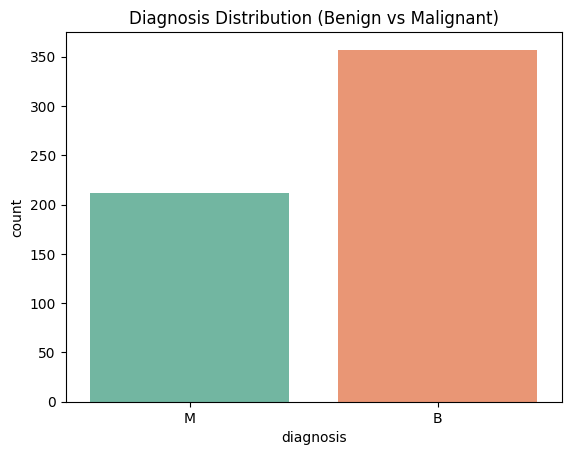

In [21]:
sns.countplot(x="diagnosis", data=data, hue="diagnosis", palette="Set2", legend=False)
plt.title("Diagnosis Distribution (Benign vs Malignant)")
plt.show()


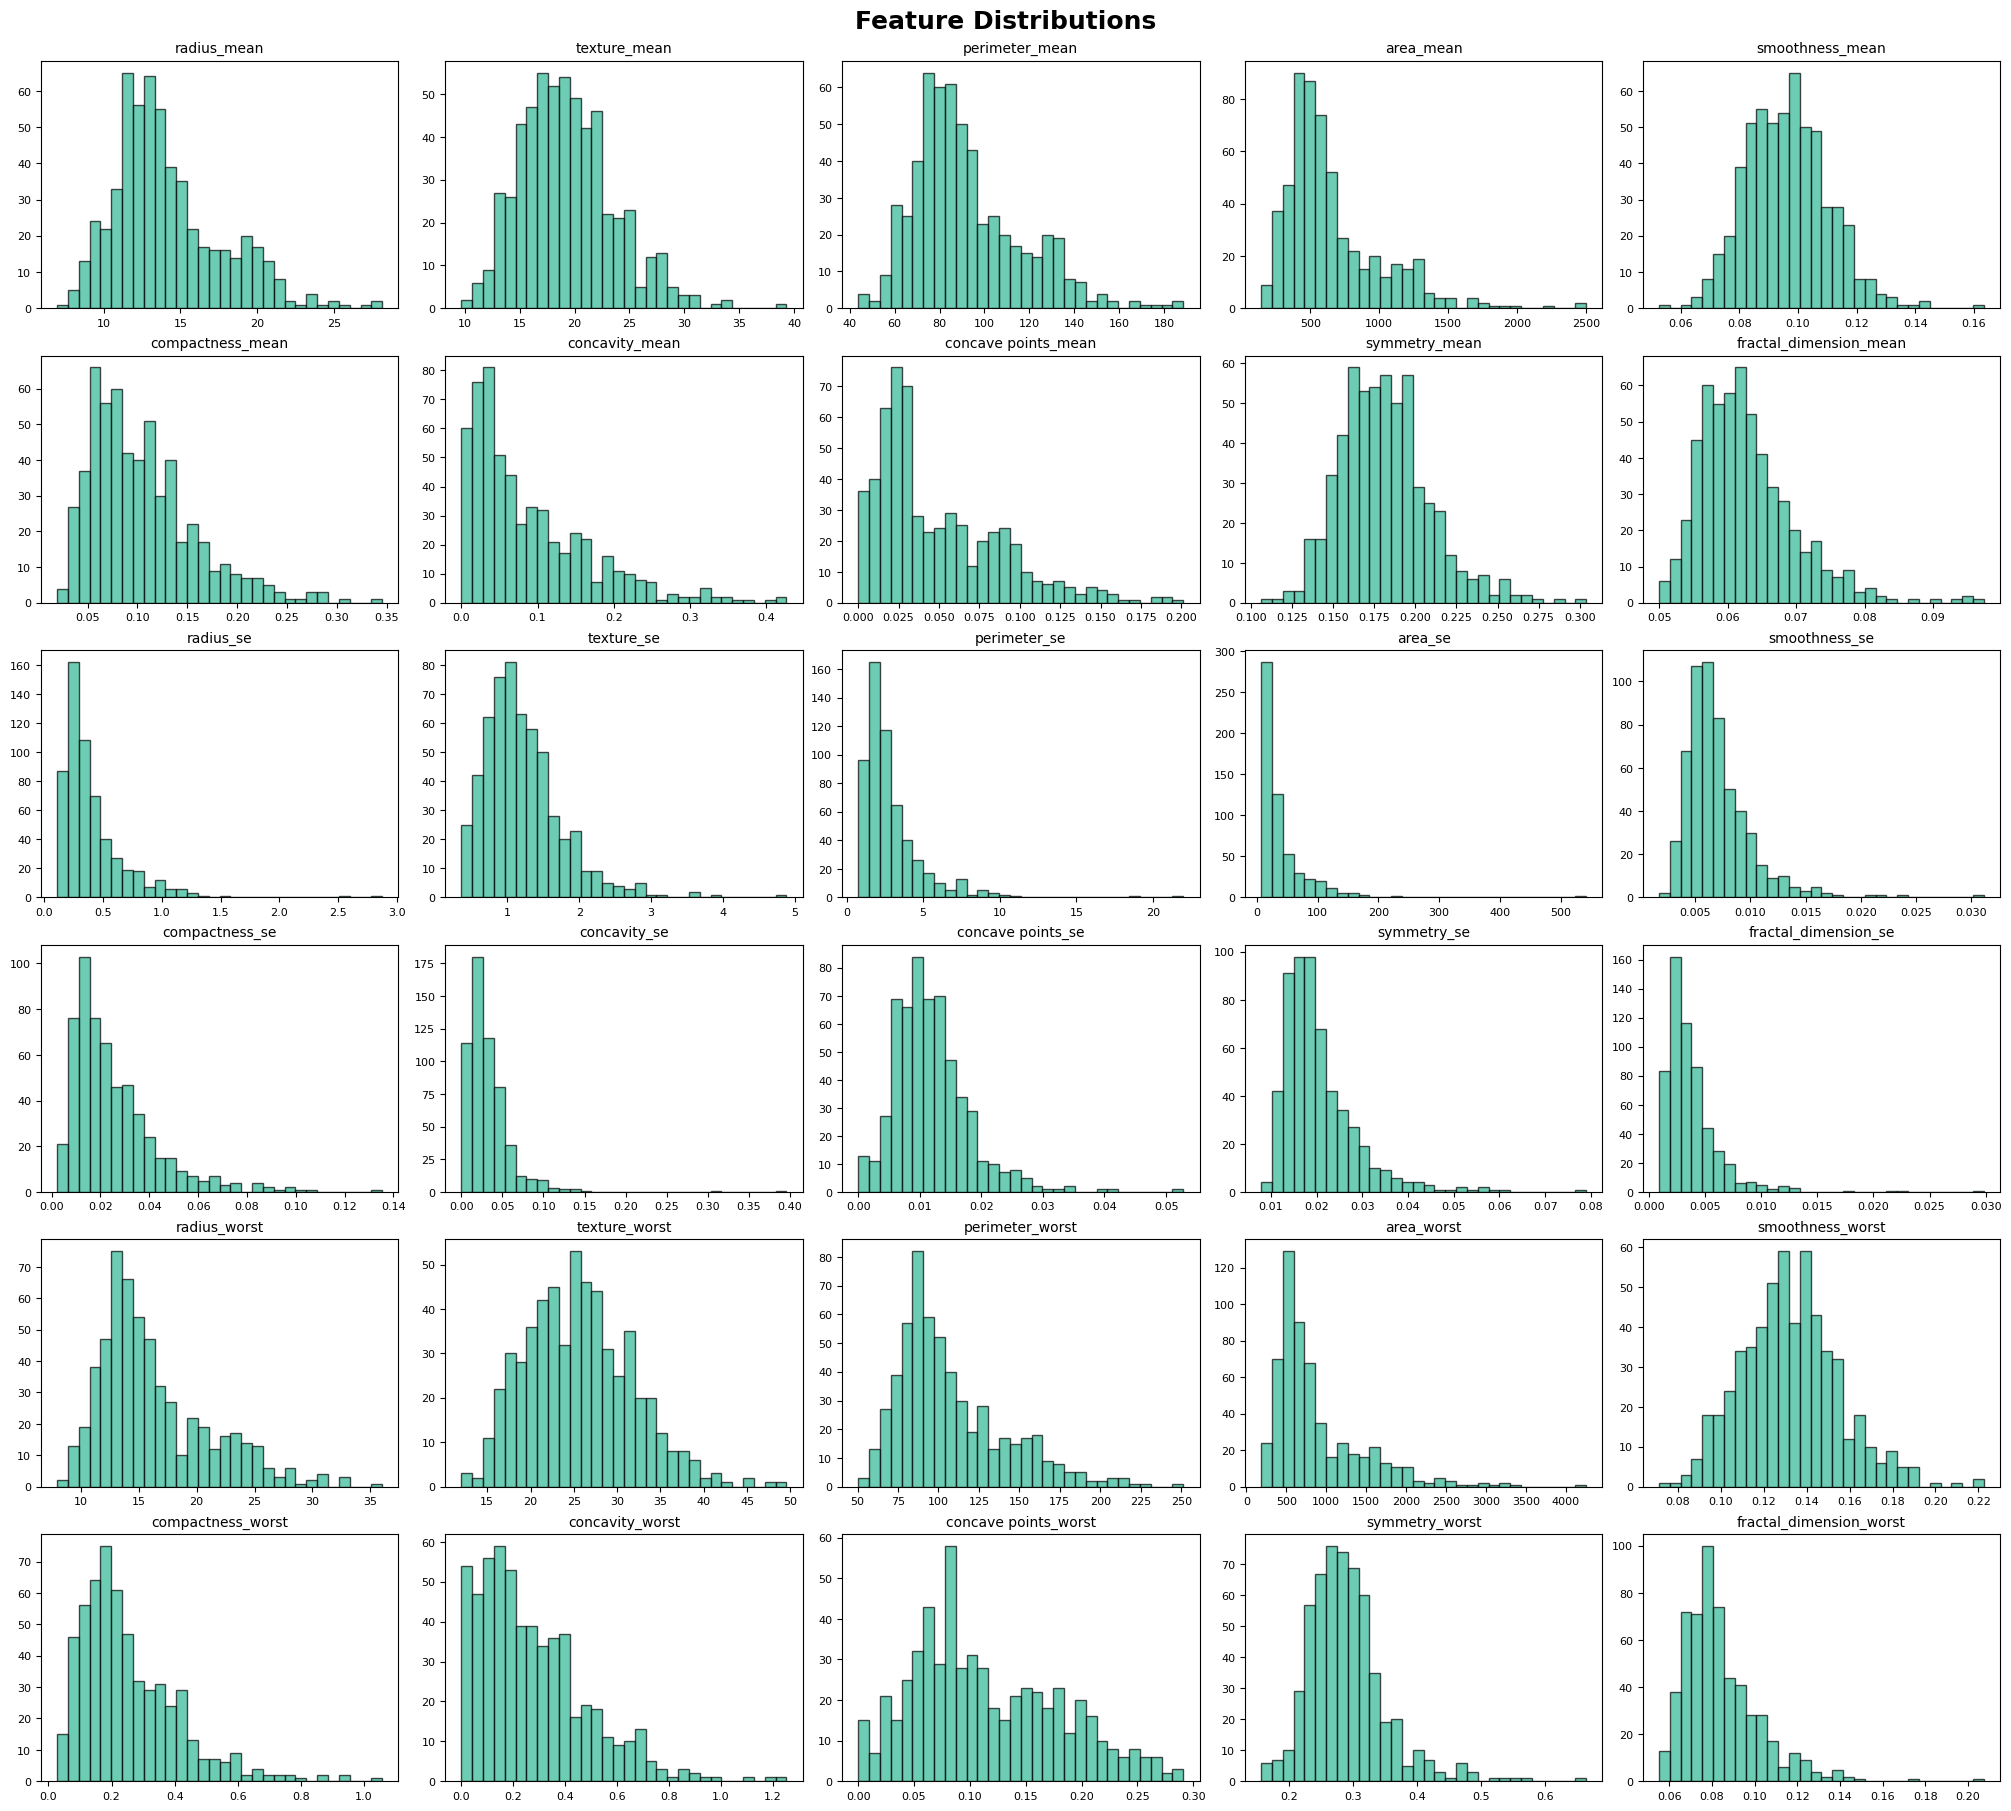

In [22]:
features = data.drop(columns=["id", "diagnosis"])

fig, axes = plt.subplots(
    nrows=6, ncols=5, figsize=(20, 18),
    constrained_layout=True
)

axes = axes.ravel()
n_features = len(features.columns)

for idx, col in enumerate(features.columns):
    axes[idx].hist(
        features[col],
        bins=30,
        color="#2FB994",
        edgecolor="black",
        alpha=0.7
    )
    axes[idx].set_title(col, fontsize=10)
    axes[idx].tick_params(axis="x", labelsize=8)
    axes[idx].tick_params(axis="y", labelsize=8)

for j in range(n_features, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Feature Distributions", fontsize=18, weight="bold")
plt.show()


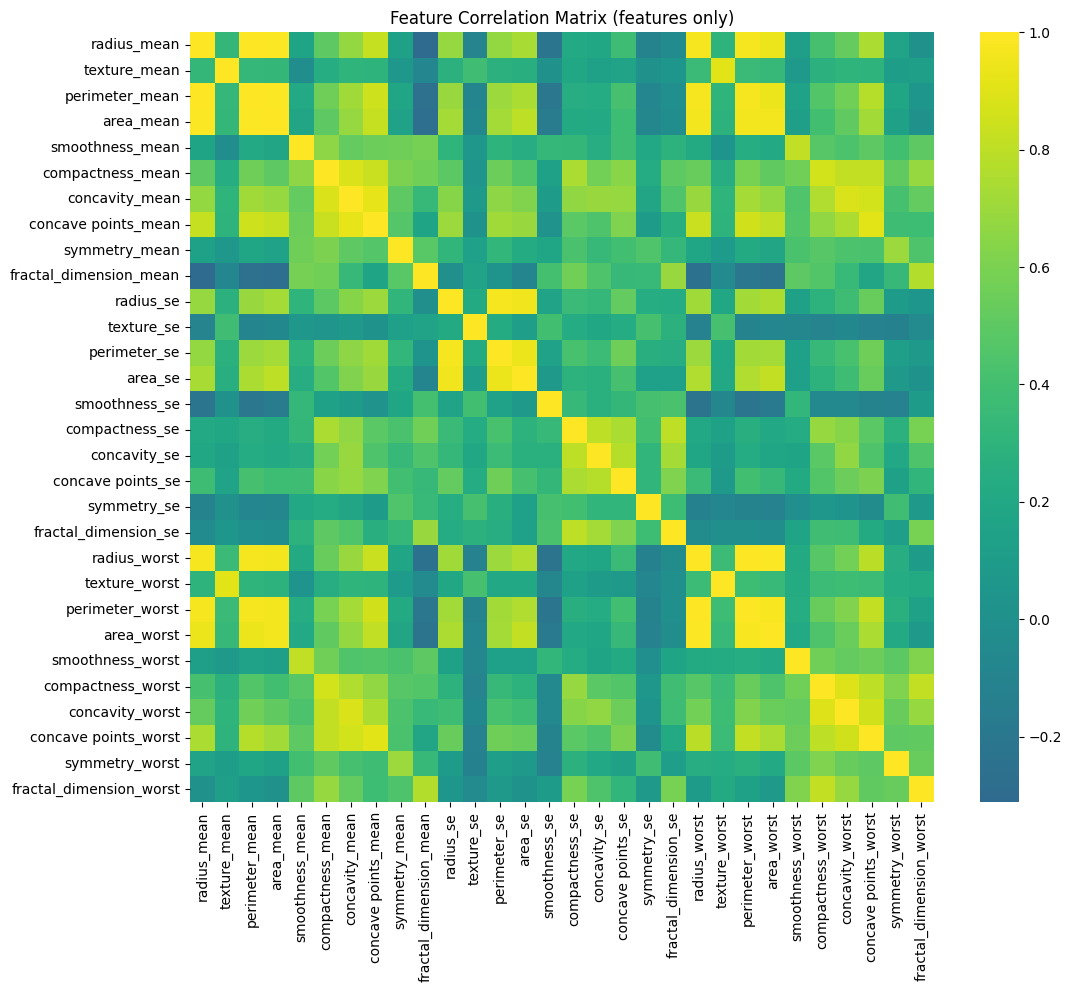

In [23]:
num = data.drop(columns=["id", "diagnosis"]).select_dtypes(include="number")
plt.figure(figsize=(12,10))
sns.heatmap(num.corr(), cmap="viridis", center=0)
plt.title("Feature Correlation Matrix (features only)")
plt.show()


## 4. Model Training and Evaluation

In [24]:
data["diagnosis"] = data["diagnosis"].map({"B": 0, "M": 1})

X = data.drop(columns=["diagnosis"])
y = data["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb, X_train, y_train, cv=cv, scoring="roc_auc")
print(f"Mean CV ROC-AUC: {cv_scores.mean():.4f}")

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")


Mean CV ROC-AUC: 0.9940
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Test ROC-AUC: 0.9970


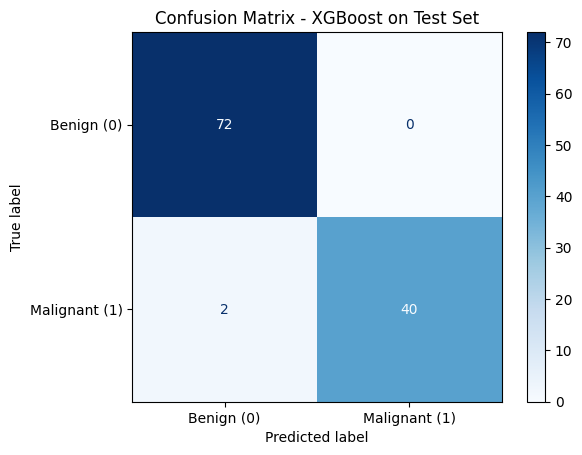

In [25]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign (0)", "Malignant (1)"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - XGBoost on Test Set")
plt.show()



Default at threshold=0.500000
              precision    recall  f1-score   support

           0     0.9730    1.0000    0.9863        72
           1     1.0000    0.9524    0.9756        42

    accuracy                         0.9825       114
   macro avg     0.9865    0.9762    0.9810       114
weighted avg     0.9829    0.9825    0.9824       114



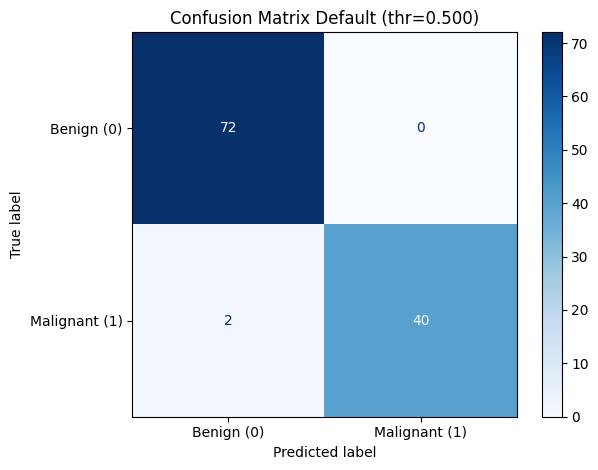


Candidate low threshold (ROC, recall=1.0): 0.015134

Recall-Prioritized at threshold=0.015134
              precision    recall  f1-score   support

           0     1.0000    0.8750    0.9333        72
           1     0.8235    1.0000    0.9032        42

    accuracy                         0.9211       114
   macro avg     0.9118    0.9375    0.9183       114
weighted avg     0.9350    0.9211    0.9222       114



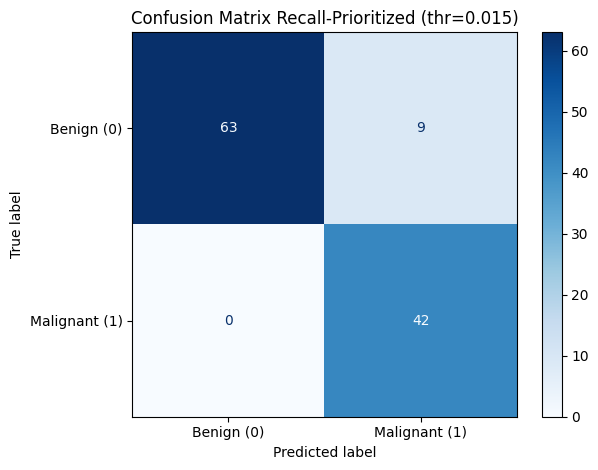

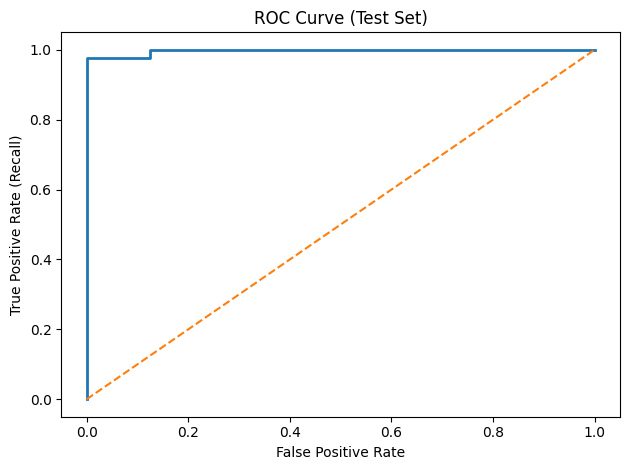

In [26]:
def evaluate_at_threshold(
    y_true, y_proba, threshold: float, title: str = ""
) -> None:
    """
    Evaluate a binary classifier at a given probability threshold.

    Args:
        y_true: True binary labels (0/1).
        y_proba: Predicted probabilities for the positive class (shape: [n]).
        threshold: Probability cutoff for predicting class 1.
        title: Title suffix for plots/prints.
    """
    y_pred = (y_proba >= threshold).astype(int)
    print(f"\n{title} at threshold={threshold:.6f}")
    print(classification_report(y_true, y_pred, digits=4))
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    ConfusionMatrixDisplay(cm, display_labels=["Benign (0)", "Malignant (1)"]).plot(
        cmap="Blues", values_format="d"
    )
    plt.title(f"Confusion Matrix {title} (thr={threshold:.3f})")
    plt.tight_layout()
    plt.show()

evaluate_at_threshold(y_test, y_proba, threshold=0.5, title="Default")

fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba)
idx_recall_1 = np.where(tpr >= 1.0 - 1e-12)[0]
thr_recall_1 = float(roc_thresholds[idx_recall_1[0]]) if len(idx_recall_1) else float(roc_thresholds[-1])

print(f"\nCandidate low threshold (ROC, recall=1.0): {thr_recall_1:.6f}")

evaluate_at_threshold(y_test, y_proba, threshold=thr_recall_1, title="Recall-Prioritized")

plt.figure()
plt.plot(fpr, tpr, lw=2)
plt.plot([0, 1], [0, 1], ls="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (Test Set)")
plt.tight_layout()
plt.show()

# NILM Unsupervised Learning: Daily Usage Profiling


In [27]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

DATASET_PATH = Path("./data/household_power_consumption.txt")


## 1. Problem Definition (Unsupervised)

**Goal:** Cluster **hours** by their electricity consumption profiles to reveal typical usage behaviors 
(e.g., low vs. high usage hours, weekday/weekend effects, seasonal shifts, appliance contributions).

There are two pipelines:

1. **Baseline**: Standardize daily features → **K-Means**.  
2. **With Dimensionality Reduction**: Standardize → **PCA (retain 95% variance)** → **K-Means**.


## 2. Load the File & Convert Dtypes

In [28]:
raw = pd.read_csv(
    DATASET_PATH,
    sep=";",
    na_values=["?", ""],
    low_memory=False
)

raw["datetime"] = pd.to_datetime(raw["Date"] + " " + raw["Time"], dayfirst=True, errors="coerce")
raw = raw.drop(columns=["Date", "Time"])

for c in raw.columns:
    if c != "datetime":
        raw[c] = pd.to_numeric(raw[c], errors="coerce")

raw = raw.dropna(subset=["datetime"]).sort_values("datetime").reset_index(drop=True)
raw.info()
raw.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48424 entries, 0 to 48423
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Global_active_power    48419 non-null  float64       
 1   Global_reactive_power  48419 non-null  float64       
 2   Voltage                48419 non-null  float64       
 3   Global_intensity       48419 non-null  float64       
 4   Sub_metering_1         48419 non-null  float64       
 5   Sub_metering_2         48419 non-null  float64       
 6   Sub_metering_3         48419 non-null  float64       
 7   datetime               48424 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(7)
memory usage: 3.0 MB


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,datetime
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00


## 3. Preprocessing
Steps:
1. **Time alignment** to exact 1-minute frequency.
2. **Interpolation** (time-based) for short gaps (dataset has ~1.25% missing).
3. **Derived feature**: *Other active energy* per minute (the portion not accounted for by sub-meterings 1-3).
4. **Hourly aggregation** to produce features per hour (sums, means, std, max, ratios).


In [29]:
data = raw.set_index("datetime")
full_idx = pd.date_range(start=data.index.min(), end=data.index.max(), freq="1min")
data = data.reindex(full_idx)

data = data.interpolate(method="time", limit_direction="both")

data["Other_active_energy_Wh"] = (
    data["Global_active_power"] * 1000.0 / 60.0
    - (data["Sub_metering_1"] + data["Sub_metering_2"] + data["Sub_metering_3"])
).clip(lower=0)

hourly = pd.DataFrame({
    "active_energy_Wh_sum": (data["Global_active_power"] * 1000.0 / 60.0).resample("1h").sum(),
    "reactive_power_mean":  data["Global_reactive_power"].resample("1h").mean(),
    "voltage_mean":         data["Voltage"].resample("1h").mean(),
    "voltage_std":          data["Voltage"].resample("1h").std(),
    "intensity_mean":       data["Global_intensity"].resample("1h").mean(),
    "intensity_max":        data["Global_intensity"].resample("1h").max(),
    "sub1_Wh_sum":          data["Sub_metering_1"].resample("1h").sum(),
    "sub2_Wh_sum":          data["Sub_metering_2"].resample("1h").sum(),
    "sub3_Wh_sum":          data["Sub_metering_3"].resample("1h").sum(),
    "other_Wh_sum":         data["Other_active_energy_Wh"].resample("1h").sum(),
    "measurements":         data["Voltage"].resample("1h").count(),
})

total_sub_h = hourly[["sub1_Wh_sum","sub2_Wh_sum","sub3_Wh_sum","other_Wh_sum"]].sum(axis=1)
eps = 1e-6
hourly["sub1_ratio"] = hourly["sub1_Wh_sum"] / (total_sub_h + eps)
hourly["sub2_ratio"] = hourly["sub2_Wh_sum"] / (total_sub_h + eps)
hourly["sub3_ratio"] = hourly["sub3_Wh_sum"] / (total_sub_h + eps)
hourly["other_ratio"] = hourly["other_Wh_sum"] / (total_sub_h + eps)
hourly[["sub1_ratio","sub2_ratio","sub3_ratio","other_ratio"]] = \
    hourly[["sub1_ratio","sub2_ratio","sub3_ratio","other_ratio"]].clip(lower=0)

hourly = hourly.dropna(subset=[
    "active_energy_Wh_sum","reactive_power_mean","voltage_mean","voltage_std",
    "intensity_mean","intensity_max","measurements"
])

hourly.head(), hourly.shape

(                     active_energy_Wh_sum  reactive_power_mean  voltage_mean  voltage_std  intensity_mean  intensity_max  sub1_Wh_sum  sub2_Wh_sum  \
 2006-12-16 17:00:00           2533.733333             0.229000    234.643889     1.528529       18.100000           33.2          0.0         19.0   
 2006-12-16 18:00:00           3632.200000             0.080033    234.580167     1.623576       15.600000           29.0          0.0        403.0   
 2006-12-16 19:00:00           3400.233333             0.085233    233.232500     0.901678       14.503333           17.4          0.0         86.0   
 2006-12-16 20:00:00           3268.566667             0.075100    234.071500     1.483866       13.916667           14.8          0.0          0.0   
 2006-12-16 21:00:00           3056.466667             0.076667    237.158667     0.862382       13.046667           14.8          0.0         25.0   
 
                      sub3_Wh_sum  other_Wh_sum  measurements  sub1_ratio  sub2_ratio  sub3_

## 4. Visual Exploration

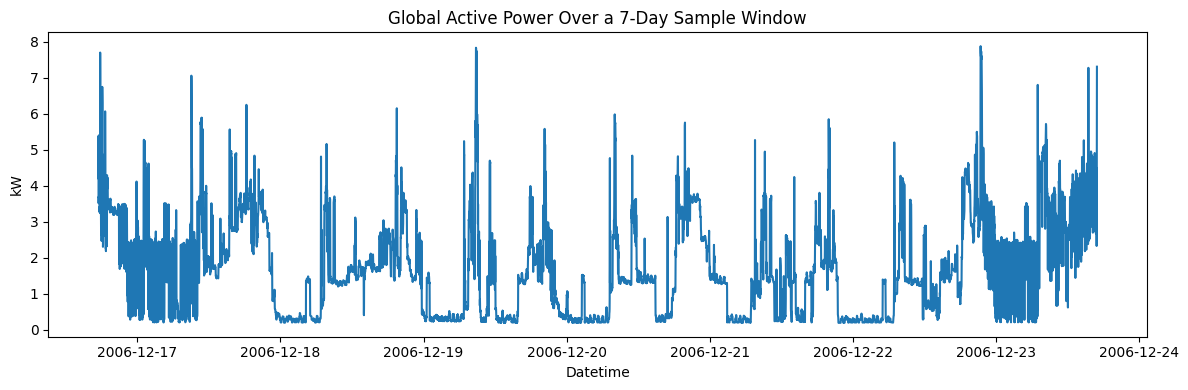

In [30]:
start_date = hourly.index.min()
end_date = start_date + pd.Timedelta(days=7)
mask = (data.index >= start_date) & (data.index < end_date)

plt.figure(figsize=(12, 4))
plt.plot(data.index[mask], data.loc[mask, "Global_active_power"])
plt.title("Global Active Power Over a 7-Day Sample Window")
plt.xlabel("Datetime")
plt.ylabel("kW")
plt.tight_layout()
plt.show()


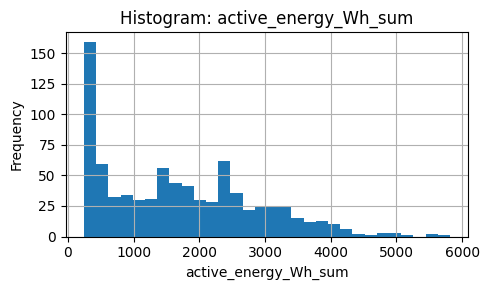

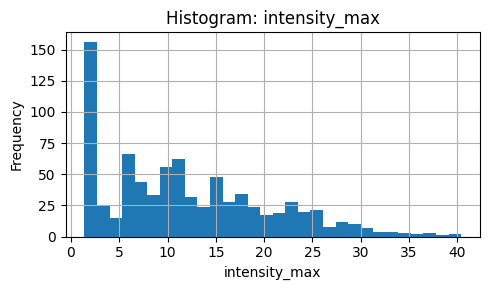

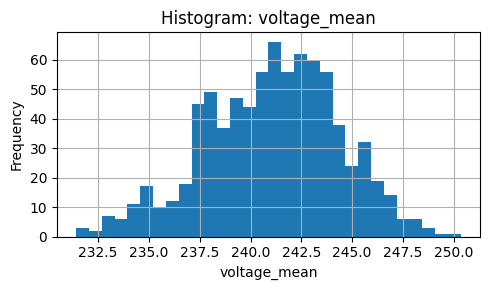

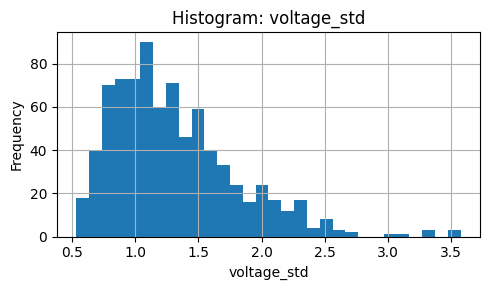

In [31]:
features_to_plot = ["active_energy_Wh_sum", "intensity_max", "voltage_mean", "voltage_std"]
for col in features_to_plot:
    plt.figure(figsize=(5, 3))
    hourly[col].hist(bins=30)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


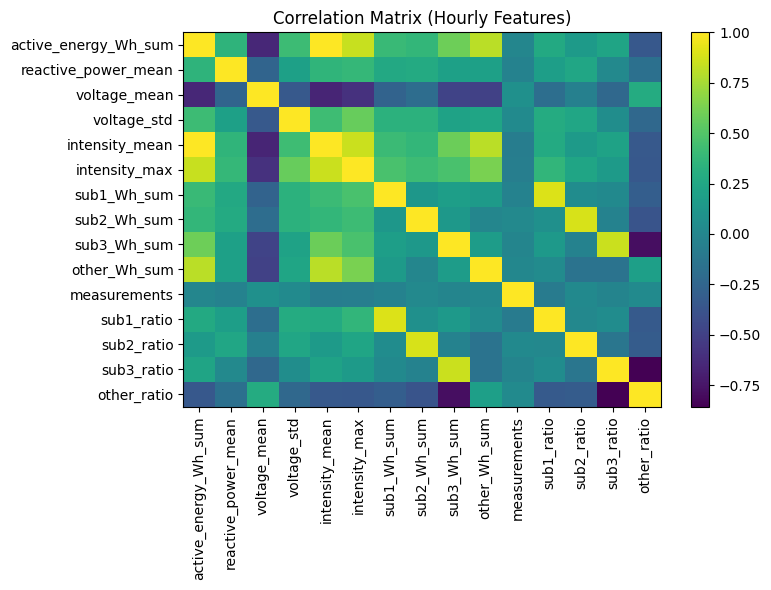

In [32]:
corr = hourly.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
plt.imshow(corr.values, aspect="auto")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation Matrix (Hourly Features)")
plt.colorbar()
plt.tight_layout()
plt.show()


## 5. Baseline Model: K-Means (No Dimensionality Reduction)

The number of cluster `k` is selected based on various indices

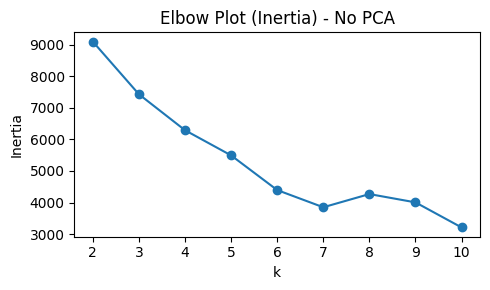

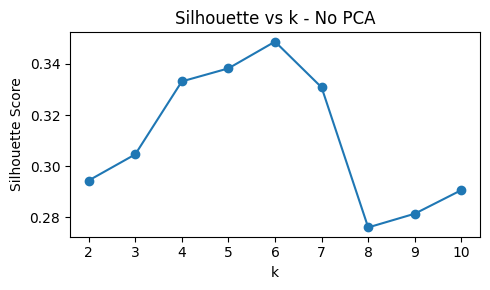

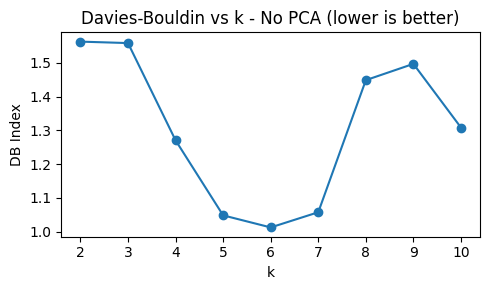

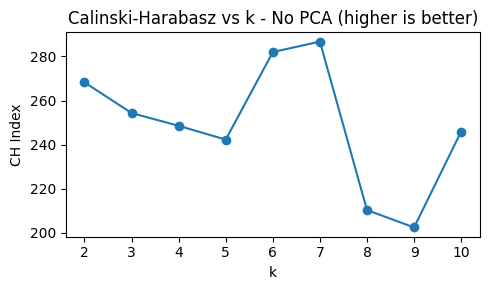

In [33]:
feature_cols = [
    "active_energy_Wh_sum", "reactive_power_mean", "voltage_mean", "voltage_std",
    "intensity_mean", "intensity_max",
    "sub1_Wh_sum", "sub2_Wh_sum", "sub3_Wh_sum", "other_Wh_sum",
    "sub1_ratio", "sub2_ratio", "sub3_ratio", "other_ratio",
    "measurements",
]
X = hourly[feature_cols].values
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

ks = list(range(2, 11))
inertias = []
sil_scores = []
db_scores = []
ch_scores = []

for k in ks:
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels = km.fit_predict(Xs)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(Xs, labels))
    db_scores.append(davies_bouldin_score(Xs, labels))
    ch_scores.append(calinski_harabasz_score(Xs, labels))

plt.figure(figsize=(5,3))
plt.plot(ks, inertias, marker="o")
plt.title("Elbow Plot (Inertia) - No PCA")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(ks, sil_scores, marker="o")
plt.title("Silhouette vs k - No PCA")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(ks, db_scores, marker="o")
plt.title("Davies-Bouldin vs k - No PCA (lower is better)")
plt.xlabel("k")
plt.ylabel("DB Index")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(ks, ch_scores, marker="o")
plt.title("Calinski-Harabasz vs k - No PCA (higher is better)")
plt.xlabel("k")
plt.ylabel("CH Index")
plt.tight_layout()
plt.show()


In [34]:
best_k_no_pca = 6
km_no_pca = KMeans(n_clusters=best_k_no_pca, n_init="auto", random_state=42)
labels_no_pca = km_no_pca.fit_predict(Xs)

hourly_no_pca = hourly.copy()
hourly_no_pca["cluster"] = labels_no_pca

summary_no_pca = hourly_no_pca.groupby("cluster").agg(
    days=("cluster", "size"),
    energy_Wh=("active_energy_Wh_sum", "mean"),
    intensity_max=("intensity_max", "mean"),
    voltage_mean=("voltage_mean", "mean"),
    sub1_ratio=("sub1_ratio", "mean"),
    sub2_ratio=("sub2_ratio", "mean"),
    sub3_ratio=("sub3_ratio", "mean"),
    other_ratio=("other_ratio", "mean"),
).sort_index()

summary_no_pca.round(2)

,days,energy_Wh,intensity_max,voltage_mean,sub1_ratio,sub2_ratio,sub3_ratio,other_ratio
cluster,,,,,,,,
0,49,3076.87,23.79,239.12,0.04,0.47,0.17,0.32
1,301,568.98,5.34,243.41,0.00,0.04,0.02,0.93
2,64,2920.09,22.89,238.97,0.25,0.03,0.27,0.45
3,173,1543.66,9.89,241.02,0.00,0.02,0.61,0.37
4,2,1887.03,24.20,235.83,0.14,0.00,0.31,0.54
5,219,2670.55,17.31,238.94,0.00,0.02,0.18,0.80


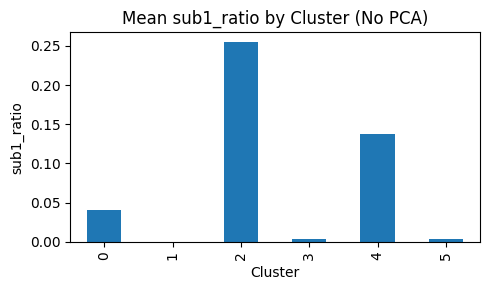

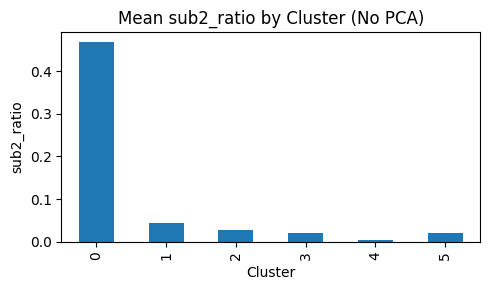

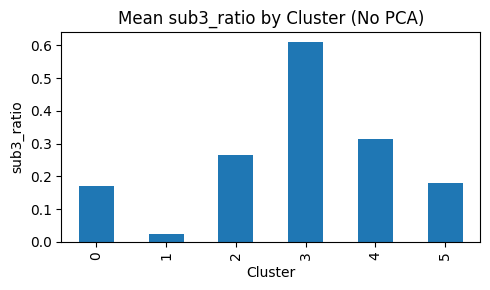

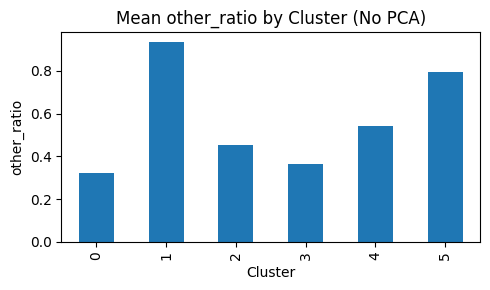

In [35]:
ratio_cols = ["sub1_ratio", "sub2_ratio", "sub3_ratio", "other_ratio"]
means = hourly_no_pca.groupby("cluster")[ratio_cols].mean()

for col in ratio_cols:
    plt.figure(figsize=(5,3))
    means[col].plot(kind="bar")
    plt.title(f"Mean {col} by Cluster (No PCA)")
    plt.xlabel("Cluster")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


## 6. Model with Dimensionality Reduction: PCA + K-Means

We keep enough components to explain **95%** of the variance, then cluster in the reduced space.

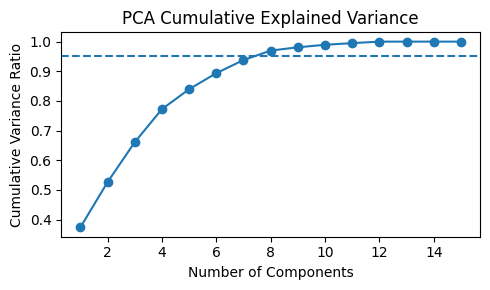

Original features: 15
PCA components kept: 8
Explained variance per component: [0.37342303 0.15238872 0.13481561 0.11146792 0.06741752 0.05402311
 0.0441971  0.03195042]
Cumulative variance: [0.37342303 0.52581174 0.66062736 0.77209527 0.83951279 0.8935359
 0.93773301 0.96968343 0.98088591 0.98930598 0.99493839 0.99995896
 1.         1.         1.        ]


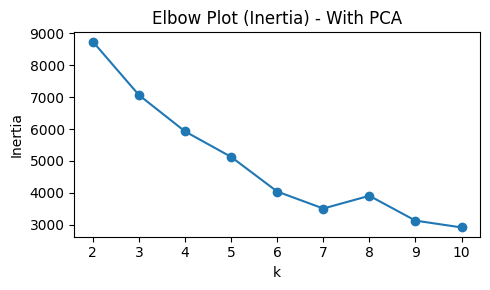

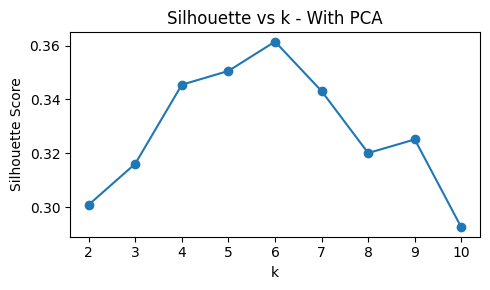

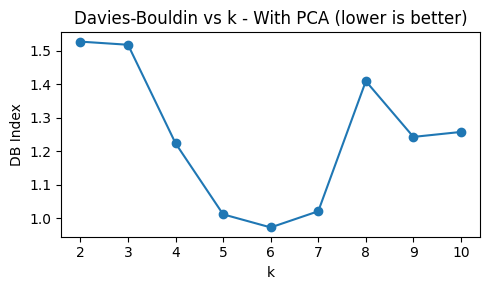

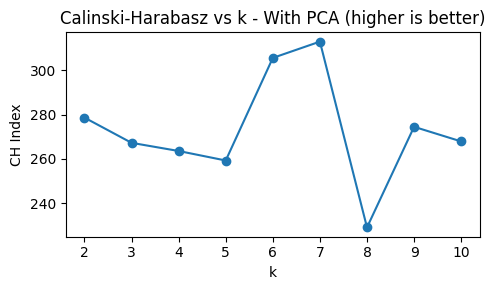

In [36]:
pca_full = PCA(svd_solver="full").fit(Xs)
cumvar = np.cumsum(pca_full.explained_variance_ratio_)
n_comp = int(np.searchsorted(cumvar, 0.95) + 1)

plt.figure(figsize=(5,3))
plt.plot(range(1, len(cumvar)+1), cumvar, marker="o")
plt.axhline(0.95, linestyle="--")
plt.title("PCA Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Ratio")
plt.tight_layout()
plt.show()

pca = PCA(n_components=n_comp, svd_solver="full")
Xp = pca.fit_transform(Xs)

print("Original features:", Xs.shape[1])
print("PCA components kept:", Xp.shape[1])
print("Explained variance per component:", pca.explained_variance_ratio_)
print("Cumulative variance:", cumvar)


ks = list(range(2, 11))
inertias_pca = []
sil_scores_pca = []
db_scores_pca = []
ch_scores_pca = []

for k in ks:
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels = km.fit_predict(Xp)
    inertias_pca.append(km.inertia_)
    sil_scores_pca.append(silhouette_score(Xp, labels))
    db_scores_pca.append(davies_bouldin_score(Xp, labels))
    ch_scores_pca.append(calinski_harabasz_score(Xp, labels))

plt.figure(figsize=(5,3))
plt.plot(ks, inertias_pca, marker="o")
plt.title("Elbow Plot (Inertia) - With PCA")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(ks, sil_scores_pca, marker="o")
plt.title("Silhouette vs k - With PCA")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(ks, db_scores_pca, marker="o")
plt.title("Davies-Bouldin vs k - With PCA (lower is better)")
plt.xlabel("k")
plt.ylabel("DB Index")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(ks, ch_scores_pca, marker="o")
plt.title("Calinski-Harabasz vs k - With PCA (higher is better)")
plt.xlabel("k")
plt.ylabel("CH Index")
plt.tight_layout()
plt.show()

In [37]:
best_k_pca = 6
km_pca = KMeans(n_clusters=best_k_pca, n_init="auto", random_state=42)
labels_pca = km_pca.fit_predict(Xp)

hourly_pca = hourly.copy()
hourly_pca["cluster"] = labels_pca

summary_pca = hourly_pca.groupby("cluster").agg(
    days=("cluster", "size"),
    energy_Wh=("active_energy_Wh_sum", "mean"),
    intensity_max=("intensity_max", "mean"),
    voltage_mean=("voltage_mean", "mean"),
    sub1_ratio=("sub1_ratio", "mean"),
    sub2_ratio=("sub2_ratio", "mean"),
    sub3_ratio=("sub3_ratio", "mean"),
    other_ratio=("other_ratio", "mean"),
).sort_index()

print({"pca_components": n_comp, "n_clusters": 6})
summary_pca.round(2)


{'pca_components': 8, 'n_clusters': 6}


,days,energy_Wh,intensity_max,voltage_mean,sub1_ratio,sub2_ratio,sub3_ratio,other_ratio
cluster,,,,,,,,
0,223,2677.07,17.27,238.89,0.00,0.02,0.19,0.79
1,305,579.49,5.42,243.37,0.00,0.04,0.02,0.93
2,63,2916.92,22.93,238.93,0.26,0.03,0.27,0.45
3,49,3076.87,23.79,239.12,0.04,0.47,0.17,0.32
4,2,1887.03,24.20,235.83,0.14,0.00,0.31,0.54
5,166,1521.43,9.79,241.15,0.00,0.02,0.62,0.36


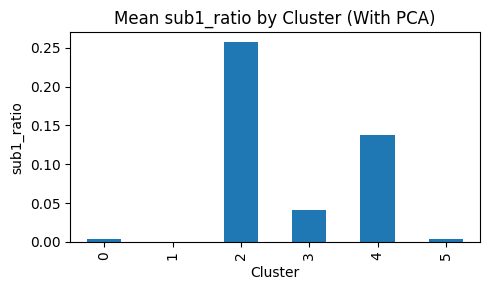

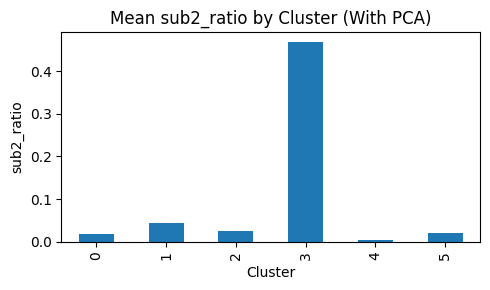

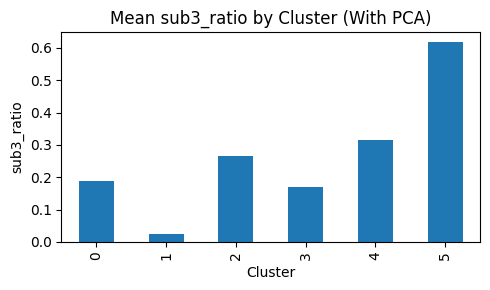

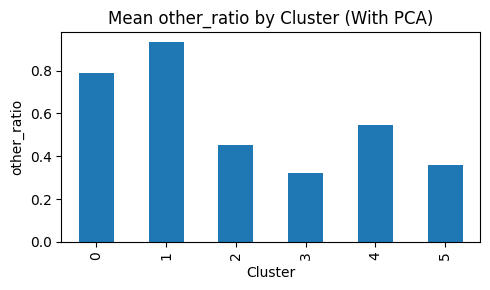

In [38]:
ratio_cols = ["sub1_ratio", "sub2_ratio", "sub3_ratio", "other_ratio"]
means_pca = hourly_pca.groupby("cluster")[ratio_cols].mean()

for col in ratio_cols:
    plt.figure(figsize=(5,3))
    means_pca[col].plot(kind="bar")
    plt.title(f"Mean {col} by Cluster (With PCA)")
    plt.xlabel("Cluster")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


## 7. Evaluation & Comparison

Comparing the selected `k` for both pipelines using multiple indices: **Silhouette**, **Davies–Bouldin**, and **Calinski–Harabasz**.

In [39]:
def evaluate_pipeline(X_embedded: np.ndarray, labels: np.ndarray) -> dict[str, float]:
    return {
        "silhouette": float(silhouette_score(X_embedded, labels)),
        "davies_bouldin": float(davies_bouldin_score(X_embedded, labels)),
        "calinski_harabasz": float(calinski_harabasz_score(X_embedded, labels)),
    }

k_no_pca = 6
k_pca    = 6

metrics_no_pca = evaluate_pipeline(Xs, labels_no_pca)
metrics_pca    = evaluate_pipeline(Xp, labels_pca)

print(f"Chosen k (No PCA): {k_no_pca}  |  {metrics_no_pca}")
print(f"Chosen k (With PCA): {k_pca}  |  {metrics_pca}")

comparison = pd.DataFrame(
    [metrics_no_pca, metrics_pca],
    index=[f"No PCA (k={k_no_pca})", f"With PCA (k={k_pca})"]
)
comparison.round(4)

Chosen k (No PCA): 6  |  {'silhouette': 0.3487553577490251, 'davies_bouldin': 1.012568681039823, 'calinski_harabasz': 282.00499634872074}
Chosen k (With PCA): 6  |  {'silhouette': 0.3614639377858955, 'davies_bouldin': 0.9721259182199044, 'calinski_harabasz': 305.66058751708334}


,silhouette,davies_bouldin,calinski_harabasz
No PCA (k=6),0.3488,1.0126,282.0050
With PCA (k=6),0.3615,0.9721,305.6606
